In [1]:
import random
import numpy as np
import queueing_tool as qt
import pandas as pd

Define service function

In [2]:
def service_f(t: float):
    """Define deterministic service time.\n
    Take the arrival time as t and add a constant.

    Args:
        t (float): current time
    """
    return t + 0.00112

def identity(t: float):
    """Handler function for returning the current time

    Args:
        t (float): current time

    Returns:
        (float): current time
    """
    return t

In [3]:
def arr_slow(t: float):
    """Return arrival time with slow rate

    Args:
        t (float): current time

    Returns:
        (float): arrival time
    """
    return t + random.expovariate(lambd=125)

def arr_fast(t: float):
    """Return arrival time with fast rate

    Args:
        t (float): current time

    Returns:
        (float): arrival time
    """
    return t + random.expovariate(lambd=500)

Define the two agents:
- slow agents that go through the whole system
- fast agents that overload the system and leave

In [4]:
class FastAgent(qt.Agent):
    def __init__(self, agent_id=(0, 0)):
        super().__init__(agent_id)
        self.agent_id = (agent_id[0], agent_id[1], 'fast')
        
class SlowAgent(qt.Agent):
    def __init__(self, agent_id=(0, 0)):
        super().__init__(agent_id)
        self.agent_id = (agent_id[0], agent_id[1], 'slow')

System definition

```mermaid
---
title: One-node M/D/1 system
---
  graph LR;
  A("Entry point")
  B("Leaving point")
  λ0("slow λ")
  λ1("fast λ")

      λ0 --> A
      λ1 --> node
      A --> node --> B
```

In [5]:
# Prepare the one-node network
q_classes = { 1: qt.QueueServer, 2: qt.QueueServer, 2: qt.QueueServer }

adja_list = {
    0: [2],
    1: [2],
    2: [3]
}
edge_list = {
    0: {2: 1},
    1: {2: 2},
    2: {3: 3}
}
g = qt.adjacency2graph(
    adjacency=adja_list,
    edge_type=edge_list
)

q_args = {
    1: {
        'arrival_f': arr_slow,
        'service_f': identity,
        'AgentFactory': SlowAgent,
    },
    2: {
        'arrival_f': arr_fast,
        'service_f': identity,
        'AgentFactory': FastAgent,
    },
    3: {
        'service_f': service_f,
    },
}

qn = qt.QueueNetwork(
    g= g, q_classes=q_classes, q_args=q_args
)

Simulate

In [13]:
qn.max_agents = np.infty

# qn.initialize()
qn.initialize(edge_type=[1, 2])
qn.start_collecting_data()
qn.simulate(n=200)
dat = qn.get_agent_data(return_header=True)

for k, v in dat[0].items():
    print(k)
    print(v)


(0, 0, 'slow')
[[0.01892571 0.01892571 0.01892571 0.         1.         0.        ]
 [0.01892571 0.01892571 0.02004571 0.         1.         2.        ]
 [0.02004571 0.         0.         0.         0.         3.        ]]
(0, 1, 'slow')
[[0.02068159 0.02068159 0.02068159 0.         1.         0.        ]
 [0.02068159 0.02068159 0.02180159 0.         1.         2.        ]
 [0.02180159 0.         0.         0.         0.         3.        ]]
(0, 2, 'slow')
[[0.02264997 0.02264997 0.02264997 0.         1.         0.        ]
 [0.02264997 0.02264997 0.02376997 0.         1.         2.        ]
 [0.02376997 0.         0.         0.         0.         3.        ]]
(0, 3, 'slow')
[[0.02362437 0.02362437 0.02377002 0.         1.         0.        ]
 [0.02377002 0.02377002 0.02489002 0.         1.         2.        ]
 [0.02489002 0.         0.         0.         0.         3.        ]]
(0, 4, 'slow')
[[0.04025883 0.04025883 0.04025883 0.         1.         0.        ]
 [0.04025883 0.04025883 

In [14]:
slow_l = []
fast_l = []
for k, v in dat[0].items():
    if k[2] == 'slow':
        slow_l.append({k: v})
    if k[2] == 'fast':
        fast_l.append({k: v})

IndexError: tuple index out of range

c:\Users\marco_\Documents\Queueing_project\queueing\venv\Lib\site-packages\queueing_tool\network\queue_network.py:566: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  animation = FuncAnimation(**animation_args)


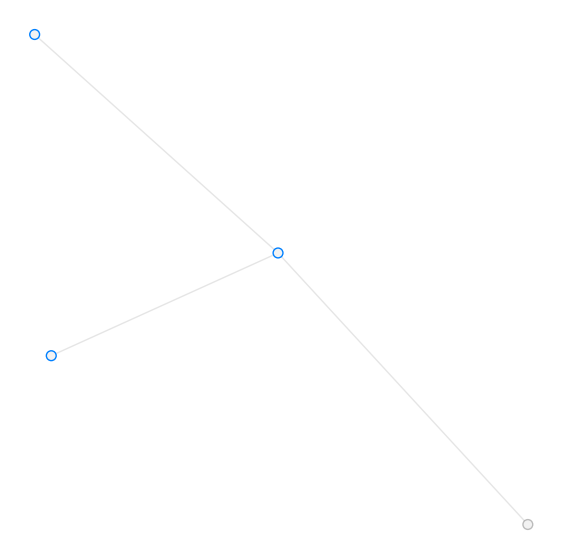

c:\Users\marco_\Documents\Queueing_project\queueing\venv\Lib\site-packages\matplotlib\animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [15]:
qn.animate()

In [16]:
for req in slow_l:
    for k, v in req.items():
        print(k)
        print(v)

(0, 0, 'slow')
[[0.01892571 0.01892571 0.01892571 0.         1.         0.        ]
 [0.01892571 0.01892571 0.02004571 0.         1.         2.        ]
 [0.02004571 0.         0.         0.         0.         3.        ]]
(0, 1, 'slow')
[[0.02068159 0.02068159 0.02068159 0.         1.         0.        ]
 [0.02068159 0.02068159 0.02180159 0.         1.         2.        ]
 [0.02180159 0.         0.         0.         0.         3.        ]]
(0, 2, 'slow')
[[0.02264997 0.02264997 0.02264997 0.         1.         0.        ]
 [0.02264997 0.02264997 0.02376997 0.         1.         2.        ]
 [0.02376997 0.         0.         0.         0.         3.        ]]
(0, 3, 'slow')
[[0.02362437 0.02362437 0.02377002 0.         1.         0.        ]
 [0.02377002 0.02377002 0.02489002 0.         1.         2.        ]
 [0.02489002 0.         0.         0.         0.         3.        ]]
(0, 4, 'slow')
[[0.04025883 0.04025883 0.04025883 0.         1.         0.        ]
 [0.04025883 0.04025883 

In [17]:
for req in fast_l:
    for k, v in req.items():
        print(k)
        print(v)

(1, 0, 'fast')
[[0.00565168 0.00565168 0.00565168 0.         1.         1.        ]
 [0.00565168 0.00565168 0.00677168 0.         1.         2.        ]
 [0.00677168 0.         0.         0.         0.         3.        ]]
(1, 1, 'fast')
[[0.00756012 0.00756012 0.00756012 0.         1.         1.        ]
 [0.00756012 0.00756012 0.00868012 0.         1.         2.        ]
 [0.00868012 0.         0.         0.         0.         3.        ]]
(1, 2, 'fast')
[[0.01314387 0.01314387 0.01314387 0.         1.         1.        ]
 [0.01314387 0.01314387 0.01426387 0.         1.         2.        ]
 [0.01426387 0.         0.         0.         0.         3.        ]]
(1, 3, 'fast')
[[0.01322893 0.01322893 0.01426392 0.         1.         1.        ]
 [0.01426392 0.01426392 0.01538392 0.         1.         2.        ]
 [0.01538392 0.         0.         0.         0.         3.        ]]
(1, 4, 'fast')
[[0.01380885 0.01426392 0.01538398 1.         2.         1.        ]
 [0.01538398 0.01538398 